1) ПРЕДВАРИТЕЛЬНАЯ ОБРАБОТКА ДАННЫХ

Подгружаем необходимые библиотеки 

In [1]:
import pandas as pd
import pdfplumber
import re
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp




Используем библиотеку pdfplumber для преобразования файла в датафрейм

In [2]:
pdf_path = r"C:\Users\User\Downloads\Nominacia studenceskie zim 01.10.2024.pdf"
with pdfplumber.open(pdf_path) as pdf:
    text = ''
    for page in pdf.pages:
        text += page.extract_text()

lines = text.split("\n")
participants = [line for line in lines if 'Санкт-Петербург' in line]
df = pd.DataFrame(participants, columns=["Участники"])

Удаляем названия вузов

In [3]:
players = df.loc[:171].copy()

substrings_to_remove = [
    'БГТУ "ВОЕНМЕХ"', 'ВТУ ЖДВ', 'ГАСУ', 'Горный университе', 'ГУАП',
    'ГУМРФ им. С.О. М', 'ИТМО', 'ЛГУ им. А.С. Пушк', 'ЛЭТИ', 'ПСПбГМУ им. И.П',
    'РГГМУ', 'РГПУ им. А.И.Герц', 'СПб ГАУ', 'СПб ГТИ(ТУ)', 'СПб ГУГА',
    'СПб ГУ', 'СПБ ГУ ПТиД', 'СПб МТУ', 'СПб ПУ', 'Санкт-Петербург'
]
pattern = '|'.join(map(re.escape, substrings_to_remove))
players['Участники'] = players['Участники'].replace(to_replace=pattern, value='', regex=True)

Удаляем лишние слова, заменяем пропуски на нулевые значения

In [4]:
def remove_first_three_words(text):
    words = text.split()
    return ' '.join(words[3:])

players['Участники'] = players['Участники'].apply(remove_first_three_words)
players['Участники'] = players['Участники'].replace(to_replace='- -', value='0', regex=True)

def is_integer(word):
    try:
        int(word)
        return True
    except ValueError:
        return False

def remove_first_word_if_not_int(text):
    words = text.split(' ', 1)
    if len(words) > 1:
        first_word, rest = words
        if not is_integer(first_word):
            return rest
    return text

players['Участники'] = players['Участники'].apply(remove_first_word_if_not_int)

Также делим общий столбец "Участники" на несколько столбцов, заменяем запятые на точки и применяем нужные типы.

In [5]:
def remove_last_words(text):
    words = text.split()
    return ' '.join(words[:4])

players['Участники'] = players['Участники'].apply(remove_last_words)

players[['born', 'sports_cat', 'weight_cat', 'best_result']] = players['Участники'].str.split(' ', n=3, expand=True)

players['best_result'] = players['best_result'].str.replace(',', '.').astype(float)

Удаляем изначальный столбец, меняем максимальные женские и мужские весовые категории, чтобы избавиться от плюса, т.к дальше для анализа нам нужны числовые значения.

Помимо этого, первые строки каждой страницы pdf файла не перенеслись, поэтому добавил их вручную.

In [6]:
players.drop(columns='Участники', inplace=True)

players['weight_cat'] = players['weight_cat'].replace({'84+': '100', '120+': '140'})
players['weight_cat'] = players['weight_cat'].astype(float)

players.loc[:50, 'gender'] = 'f'
players.loc[51:, 'gender'] = 'm'

new_rows = pd.DataFrame({
    'born': ['2000', '2002', '2002', '2006', '2005'],
    'sports_cat': ['КМС', 'КМС', '-', '1', '-'],
    'weight_cat': [63, 59, 74, 83, 120],
    'best_result': [67.5, 100.0, 0, 0, 135.0],
    'gender': ['f', 'm', 'm', 'm', 'm']
})
players = pd.concat([players, new_rows], ignore_index=True)

Разделим датафреймы по половому признаку и по наличию результатов. 

К сожалению, у многих (примерно половины) спортсменов не был занесен их лучший результат в жиме, что сильно уменьшило выборку до 72 строк. Однако это всё равно позволит нам сделать интересные заключения. В итоге у нас получается такой датафрейм, содержащий данные о результатах мужчин

In [18]:
male_players = players.query('gender == "m"')
female_players = players.query('gender == "f"')

male_with_results = male_players.query('best_result != 0')
female_with_results = female_players.query('best_result != 0')
male_with_results

,born,sports_cat,weight_cat,best_result,gender
51,2002,КМС,59.0,100.0,m
52,2005,КМС,59.0,92.5,m
53,2005,1,59.0,90.0,m
54,2003,-,59.0,87.5,m
55,2001,-,59.0,75.0,m
...,...,...,...,...,...
155,1999,2,105.0,140.0,m
156,2005,-,105.0,120.0,m
168,2001,-,140.0,132.5,m
173,2002,КМС,59.0,100.0,m


2) ОПИСАТЕЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ И ВИЗУАЛИЗАЦИЯ

Можно заметить, что присутствует мутант (как выяснится позже, их двое), который жмет 180. Тем не менее, мой лучший результат (120) выше среднего, медианы и моды, что не может не радовать

In [8]:
print(male_with_results['best_result'].max())
print(male_with_results['best_result'].min())

mean_values = male_with_results['best_result'].mean()
median_values = male_with_results['best_result'].median()
mode_values = male_with_results['best_result'].mode()

print(mean_values)
print(median_values)
print(mode_values)

180.0
75.0
112.74305555555556
110.0
0    100.0
Name: best_result, dtype: float64


Если говорить про мою весовую категорию (до 83 кг), то я совсем немного выше среднего по основным показателям. 

In [9]:
mean_values_83 = male_with_results.query('weight_cat == 83')['best_result'].mean()
median_values_83 = male_with_results.query('weight_cat == 83')['best_result'].median()
mode_values_83 = male_with_results.query('weight_cat == 83')['best_result'].mode()

print(mean_values_83)
print(median_values_83)
print(mode_values_83)

113.21428571428571
115.0
0    100.0
Name: best_result, dtype: float64


Добавим две визуализации с распределением результатов. Первая - обычное распределение, вторая содержит разбиение на весовые и линию корреляции.

По второй несложно заметить, что вес определенно имеет отношение к результату спортсмена. 

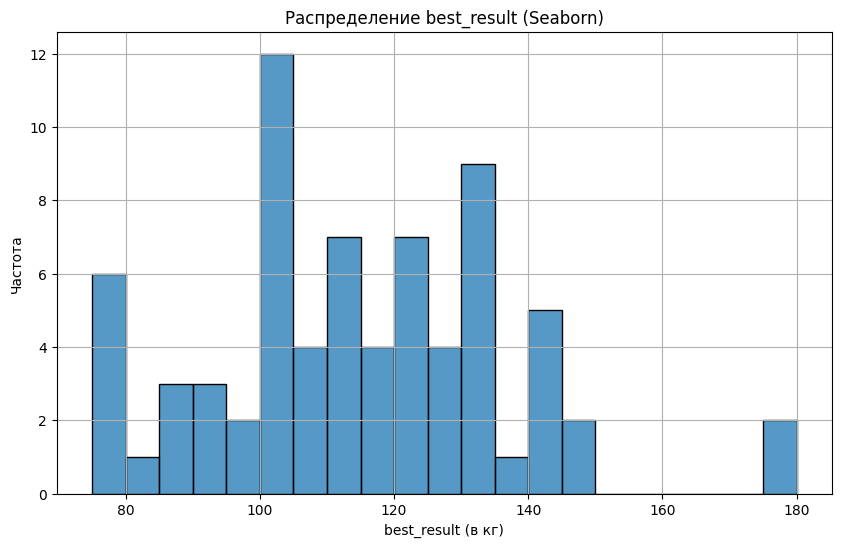

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(
    male_with_results['best_result'],
    bins=range(
        int(male_with_results['best_result'].min()),
        int(male_with_results['best_result'].max()) + 5, 5
    ),
    kde=False
)
plt.title('Распределение best_result (Seaborn)')
plt.xlabel('best_result (в кг)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

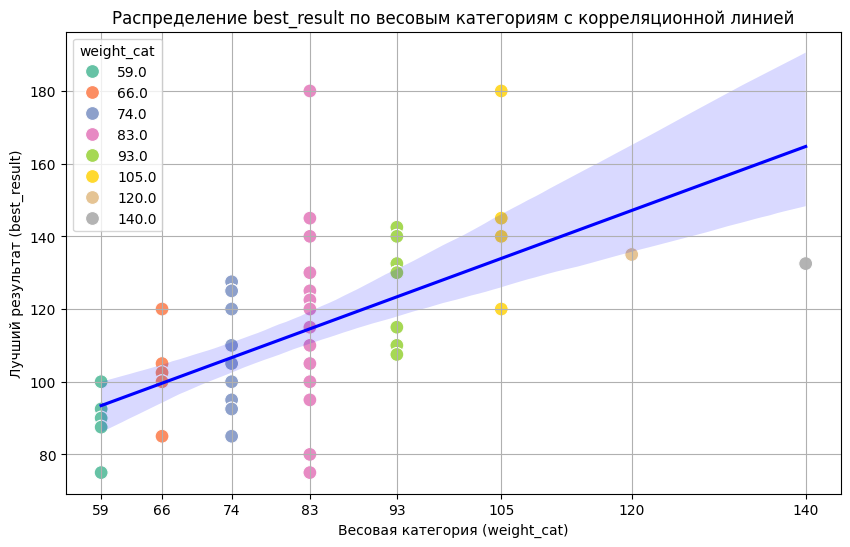

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=male_with_results,
    x='weight_cat',
    y='best_result',
    hue='weight_cat',
    palette='Set2',
    s=100
)
sns.regplot(
    data=male_with_results,
    x='weight_cat',
    y='best_result',
    scatter=False,
    color='blue'
)
plt.xticks(
    ticks=[59, 66, 74, 83, 93, 105, 120, 140],
    labels=[59, 66, 74, 83, 93, 105, 120, 140]
)
plt.title('Распределение best_result по весовым категориям с корреляционной линией')
plt.xlabel('Весовая категория (weight_cat)')
plt.ylabel('Лучший результат (best_result)')
plt.grid(True)
plt.show()

Также проведя тест Шапиро-Уилка, получаем что данные распределены ненормально: p-value = 0.037, что меньше 0.05. 

In [12]:
stat, p_value = stats.shapiro(male_with_results['best_result'])
print(f"Shapiro-Wilk test: Statistic={stat}, p-value={p_value}")

stat_filtered, p_value_filtered = stats.shapiro(
    male_with_results.query('best_result != 180.0')['best_result']
)
print(f"Shapiro-Wilk test (без 180.0): Statistic={stat_filtered}, p-value={p_value_filtered}")

Shapiro-Wilk test: Statistic=0.959524219705579, p-value=0.020769541703241065
Shapiro-Wilk test (без 180.0): Statistic=0.9630805844800355, p-value=0.037125005966659526


Строим матрицу корреляции, которая отображает связь показателей года рождения, весовой категории и лучшего результата спортсмена. 

 Из интересного: можно заметить достаточно сильную корреляцию между весовой категорий и лучшим результатом, при этом слабую корреляцию между годом рождения и результатом. Возведя результаты в квадрат, получаем коэффициент детерминации (R^2). Он говорит, что до ~6%   результатов можно объяснить годом рождения человека (чем старше, тем лучше результат), и что до ~35%  результатов можно объяснить весом участника. 

In [13]:
correlation_matrix = male_with_results[['born', 'weight_cat', 'best_result']].corr()
print(correlation_matrix)

                 born  weight_cat  best_result
born         1.000000   -0.192442    -0.244256
weight_cat  -0.192442    1.000000     0.592626
best_result -0.244256    0.592626     1.000000


3) СТАТИСТИЧЕСКИЕ СРАВНЕНИЯ 74Б 83 И 93 ВЕСОВЫХ КАТЕГОРИЙ

Сравним основные показатели (главное- среднее) трех категорий

In [14]:
male_74 =male_with_results.query('weight_cat == 74')
male_83 =male_with_results.query('weight_cat == 83')
male_93 =male_with_results.query('weight_cat == 93')

comparison = pd.DataFrame ({'weight_cat':[74, 83, 93],'mean': [male_74.best_result.mean(), male_83.best_result.mean(), male_93.best_result.mean()], 'mode': [male_74.best_result.mode()[0], male_83.best_result.mode()[0], male_93.best_result.mode()[0]], 'median': [male_74.best_result.median(), male_83.best_result.median(), male_93.best_result.median()],
    'max': [male_74.best_result.max(), male_83.best_result.max(), male_93.best_result.max()],
    'min': [male_74.best_result.min(), male_83.best_result.min(), male_93.best_result.min()]})
comparison

,weight_cat,mean,mode,median,max,min
0,74,108.333333,100.0,110.0,127.5,85.0
1,83,113.214286,100.0,115.0,180.0,75.0
2,93,125.714286,130.0,130.0,142.5,107.5


Проверяем нормальность распределения, где выясняем, что 93 категория распределена ненормально (p-value < 0.05). Это позволяет нам провести непараметрический тест Краскела-Уоллиса, который не требует нормальности распределений и большой выборки. 

Тест подтверждает, что существует хотя бы одна значимая разница между этими группами 

In [15]:
stat74, p74 = stats.shapiro(male_74['best_result'])
stat83, p83 = stats.shapiro(male_83['best_result'])
stat93, p93 = stats.shapiro(male_93['best_result'])

print(f"Весовая категория 74: Statistic={stat74}, p-value={p74}")
print(f"Весовая категория 83: Statistic={stat83}, p-value={p83}")
print(f"Весовая категория 93: Statistic={stat93}, p-value={p93}")

kruskal_result = kruskal(
    male_74['best_result'],
    male_83['best_result'],
    male_93['best_result'],
)
print(f"Kruskal-Wallis H-статистика: {kruskal_result.statistic}, p-value: {kruskal_result.pvalue}")

Весовая категория 74: Statistic=0.9487504633375695, p-value=0.5049905024934114
Весовая категория 83: Statistic=0.9481935652732456, p-value=0.31474515414682946
Весовая категория 93: Statistic=0.8607445903371022, p-value=0.031176696746381176
Kruskal-Wallis H-статистика: 9.198097843630974, p-value: 0.01006140037395879


Проводим тест Манна-Уитни для сравнения групп попарно, чтобы выяснить, какие именно группы отличается

In [16]:
stat_83_93, p_83_93 = mannwhitneyu(
    male_83['best_result'],
    male_93['best_result']
)
stat_74_83, p_74_83 = mannwhitneyu(
    male_74['best_result'],
    male_83['best_result']
)
stat_74_93, p_74_93 = mannwhitneyu(
    male_74['best_result'],
    male_93['best_result']
)

print(f"Сравнение 83 и 93: p-value = {p_83_93}")
print(f"Сравнение 74 и 83: p-value = {p_74_83}")
print(f"Сравнение 74 и 93: p-value = {p_74_93}")

Сравнение 83 и 93: p-value = 0.03741686585286501
Сравнение 74 и 83: p-value = 0.5506581497434486
Сравнение 74 и 93: p-value = 0.0015612499425901399


Чтобы правильно оценить различия в группах, необходимо сделать поправку на множественные сравнения и скорректировать альфу у каждого p значения. 

Используем метод Холма, который не так консервативен, как поправка Бонферрони. 

Сначала нужно отсортировать исходные p-values по возрастанию: 0.00156 (для сравнения категорий 74 и 93), 0.03741 (83 и 93) и 0.55066 (74 и 83). Далее проводится корректировка p-value. Для наименьшего p-value (74 и 93) оно умножается на 3, что даёт скорректированное значение 0.00468. Для следующего по величине p-value (83 и 93) оно умножается на 2, и скорректированное значение составляет 0.07482. Последнее p-value (74 и 83) умножается на 1, что даёт то же значение 0.55066.

В нашем случае только различие между весовыми категориями 74 и 93 является значимым, так как скорректированное p-value составляет 0.00468, что меньше 0.05. Различия между категориями 83 и 93, а также 74 и 83 незначимы, так как их p-values больше 0.05.



На простом языке можно сказать следующее:
результаты спортсменов в весовых категориях 74 кг и 93 кг статистически отличаются, то есть их достижения в лучшем результате действительно разные. Спортсмены из этих двух категорий показывают разные уровни результата. В то же время, спортсмены в категориях 74 кг и 83 кг, а также 83 кг и 93 кг, показывают схожие результаты, и их различия в достижениях несущественны с точки зрения статистики.